In [ ]:
import pandas as pd
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")
print("Path to dataset files:", path)

# File names to be processed
list_filenames = [
    "PRSA_Data_Guanyuan_20130301-20170228.csv",
    "PRSA_Data_Aotizhongxin_20130301-20170228.csv",
    "PRSA_Data_Wanliu_20130301-20170228.csv",
    "PRSA_Data_Tiantan_20130301-20170228.csv",
    "PRSA_Data_Wanshouxigong_20130301-20170228.csv",
    "PRSA_Data_Nongzhanguan_20130301-20170228.csv",
    "PRSA_Data_Shunyi_20130301-20170228.csv",
    "PRSA_Data_Changping_20130301-20170228.csv",
    "PRSA_Data_Dingling_20130301-20170228.csv",
    "PRSA_Data_Huairou_20130301-20170228.csv",
    "PRSA_Data_Gucheng_20130301-20170228.csv",
    "PRSA_Data_Dongsi_20130301-20170228.csv"
]

# Load datasets into a list of dataframes
dataframes = []
for filename in list_filenames:
    full_path = f"{path}/{filename}"
    df = pd.read_csv(full_path)
    df['site'] = filename.split('_')[2]  # Add site identifier
    dataframes.append(df)

# Combine all dataframes into one
combined_data = pd.concat(dataframes, ignore_index=True)

# Display combined data structure
print("Combined Dataset Info:")
print(combined_data.info())

100%|██████████| 8.58M/8.58M [00:00<00:00, 80.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sid321axn/beijing-multisite-airquality-data-set/versions/1
Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  statio

In [ ]:
import pandas as pd
import numpy as np

# Create a datetime column
combined_data['datetime'] = pd.to_datetime(combined_data[['year', 'month', 'day', 'hour']])
combined_data = combined_data.sort_values(by='datetime')
print("Data sorted by datetime successfully.")
print(combined_data[['datetime', 'year', 'month', 'day', 'hour']].head())

# Drop columns with excessive missing values
threshold = 0.5 * len(combined_data)
combined_data_cleaned = combined_data.dropna(axis=1, thresh=threshold)

# Fill remaining missing values
combined_data_cleaned = combined_data_cleaned.ffill().fillna(0)

# ------------------------
# Temporal Features
# ------------------------
combined_data_cleaned['hour'] = combined_data_cleaned['datetime'].dt.hour
combined_data_cleaned['day'] = combined_data_cleaned['datetime'].dt.day
combined_data_cleaned['month'] = combined_data_cleaned['datetime'].dt.month
combined_data_cleaned['year'] = combined_data_cleaned['datetime'].dt.year
combined_data_cleaned['day_of_week'] = combined_data_cleaned['datetime'].dt.dayofweek
combined_data_cleaned['is_weekend'] = combined_data_cleaned['day_of_week'].isin([5, 6]).astype(int)

# ------------------------
# Target Variable
# ------------------------
combined_data_cleaned['target_7_days_ahead'] = combined_data_cleaned['PM2.5'].shift(-7)

# ------------------------
# Spatial Feature
# ------------------------
combined_data_cleaned['city_id'] = combined_data_cleaned['site'].astype('category').cat.codes

# ------------------------
# Lag Features
# ------------------------
lag_features = ['PM2.5', 'PM10', 'O3']
for feature in lag_features:
    for lag in range(1, 8):
        combined_data_cleaned[f'{feature}_lag_{lag}'] = combined_data_cleaned[feature].shift(lag)

# ------------------------
# Rolling Statistics
# ------------------------
for feature in lag_features:
    combined_data_cleaned[f'{feature}_rolling_mean'] = combined_data_cleaned[feature].rolling(window=7).mean()
    combined_data_cleaned[f'{feature}_rolling_std'] = combined_data_cleaned[feature].rolling(window=7).std()

# ------------------------
# Seasonal and Holiday Features
# ------------------------
combined_data_cleaned['season'] = (combined_data_cleaned['month'] % 12) // 3 + 1

holiday_dates = pd.to_datetime([
    "2013-10-01", "2014-10-01", "2015-10-01", "2016-10-01", "2017-10-01",  # National Day
    "2014-01-31", "2015-02-19", "2016-02-08", "2017-01-28"                 # Chinese New Year
])
combined_data_cleaned['is_holiday'] = combined_data_cleaned['datetime'].dt.date.isin(holiday_dates.date).astype(int)

# ------------------------
# Interaction Features and Trends
# ------------------------
combined_data_cleaned['TEMP_PM25'] = combined_data_cleaned['TEMP'] * combined_data_cleaned['PM2.5']
combined_data_cleaned['TEMP_diff'] = combined_data_cleaned['TEMP'].diff().fillna(0)
combined_data_cleaned['PM25_diff'] = combined_data_cleaned['PM2.5'].diff().fillna(0)
combined_data_cleaned['PM2.5_rolling_max'] = combined_data_cleaned['PM2.5'].rolling(window=7).max()
combined_data_cleaned['PM2.5_change_rate'] = combined_data_cleaned['PM2.5'].pct_change().fillna(0)

# ------------------------
# Drop rows with NaNs introduced by lags or rolling
# ------------------------
combined_data_cleaned = combined_data_cleaned.dropna()
print("Processed Dataset Info:")
print(combined_data_cleaned.info())
print(combined_data_cleaned.head())

# ------------------------
# Save to CSV
# ------------------------
combined_data_cleaned.to_csv('processed_beijing_airquality_data_v2.csv', index=False)
print("✅ Saved to 'processed_beijing_airquality_data_v2.csv'")


Data sorted by datetime successfully.
         datetime  year  month  day  hour
0      2013-03-01  2013      3    1     0
315576 2013-03-01  2013      3    1     0
70128  2013-03-01  2013      3    1     0
350640 2013-03-01  2013      3    1     0
35064  2013-03-01  2013      3    1     0
Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 420754 entries, 385704 to 245447
Data columns (total 58 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   No                   420754 non-null  int64         
 1   year                 420754 non-null  int32         
 2   month                420754 non-null  int32         
 3   day                  420754 non-null  int32         
 4   hour                 420754 non-null  int32         
 5   PM2.5                420754 non-null  float64       
 6   PM10                 420754 non-null  float64       
 7   SO2                  420754 non-null  float64   

In [ ]:
!pip install tensorflow
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip show keras

Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: keras-tuner, tensorflow


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
import joblib

# ---------------------------------------
# 1. Feature Selection
# ---------------------------------------
# Ensure target is last column
numeric_columns = combined_data_cleaned.select_dtypes(include=[np.number]).columns.tolist()
if 'target_7_days_ahead' in numeric_columns:
    numeric_columns.remove('target_7_days_ahead')
numeric_columns.append('target_7_days_ahead')

# Extract as numpy array
data_array = combined_data_cleaned[numeric_columns].values

# ---------------------------------------
# 2. Sequence Preparation
# ---------------------------------------
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])  # all features
        y.append(data[i + sequence_length, -1])     # target value
    return np.array(X), np.array(y)

sequence_length = 7
X, y = create_sequences(data_array, sequence_length)

# ---------------------------------------
# 3. Train-test Split
# ---------------------------------------
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ---------------------------------------
# 4. Normalization
# ---------------------------------------
scaler = StandardScaler()

# Reshape for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit-transform train and transform test
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Save the scaler for later
joblib.dump(scaler, 'lstm_scaler.pkl')

# ---------------------------------------
# 5. Build Model with Keras Tuner
# ---------------------------------------
def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # single output
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Search best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test), verbose=1)

# ---------------------------------------
# 6. Final Model Training
# ---------------------------------------
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best LSTM hyperparameters:", best_hp.values)

lstm_model = build_lstm_model(best_hp)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

lstm_model.fit(X_train_scaled, y_train,
               epochs=20,
               batch_size=32,
               validation_data=(X_test_scaled, y_test),
               callbacks=[early_stopping],
               verbose=1)

# ---------------------------------------
# 7. Predict on Train/Test for Metrics
# ---------------------------------------
lstm_preds_train = lstm_model.predict(X_train_scaled).flatten()
lstm_preds_test = lstm_model.predict(X_test_scaled).flatten()

np.save('lstm_preds_train.npy', lstm_preds_train)
np.save('lstm_preds_test.npy', lstm_preds_test)

# ---------------------------------------
# 8. Predict on Full Timeline
# ---------------------------------------
# Reshape and scale all data
X_all_reshaped = X.reshape(-1, X.shape[-1])
X_all_scaled = scaler.transform(X_all_reshaped).reshape(X.shape)

# Predict for full data
lstm_preds_full = lstm_model.predict(X_all_scaled).flatten()

# Align predictions with original timeline
lstm_preds_full_aligned = np.concatenate([
    np.full(sequence_length, np.nan),  # pad start
    lstm_preds_full
])

np.save('lstm_preds_full.npy', lstm_preds_full_aligned)

# Save model
lstm_model.save('best_lstm_model.keras')
print("✅ Full LSTM model and predictions saved.")


Trial 4 Complete [00h 02m 15s]
val_loss: 1173.046142578125

Best val_loss So Far: 984.2796630859375
Total elapsed time: 00h 12m 02s
Best LSTM hyperparameters: {'units': 96, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Epoch 1/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - loss: 3841.4580 - val_loss: 1070.8112
Epoch 2/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 133s 7ms/step - loss: 961.1282 - val_loss: 995.3943
Epoch 3/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 907.4109 - val_loss: 1001.2088
Epoch 4/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 901.9573 - val_loss: 989.0269
Epoch 5/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - loss: 899.3722 - val_loss: 971.1630
Epoch 6/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - loss: 877.6035 - val_loss: 974.7192
Epoch 7/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - loss: 891.5378 - val_loss: 977.3479
Epoch 8/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 893.4108 -

In [ ]:
from keras.models import load_model  # Native Keras loader


lstm_model = load_model('/content/best_lstm_model.keras', compile=False)
print(lstm_model)

<Sequential name=sequential_1, built=True>


In [ ]:


# Confirm it's a file, not a directory
import os
print("Is file:", os.path.isfile("best_lstm_model.keras"))  # Should print True


Is file: True


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# ---------------------------------------
# 1. Load Data and LSTM Predictions
# ---------------------------------------
lstm_preds_full = np.load('lstm_preds_full.npy')  # full timeline predictions
scaler_lstm = joblib.load('lstm_scaler.pkl')  # if you want to reuse it

# Select features
features = [
    'PM2.5_lag_1', 'PM10_lag_1', 'O3_lag_1',
    'PM2.5_rolling_mean', 'PM10_rolling_mean', 'O3_rolling_mean'
]
X = combined_data_cleaned[features].copy()
y = combined_data_cleaned['target_7_days_ahead']

# Drop rows with NaN in LSTM predictions
valid_mask = ~np.isnan(lstm_preds_full)
X_valid = X[valid_mask].copy()
y_valid = y[valid_mask].copy()
lstm_preds_valid = lstm_preds_full[valid_mask]

# ---------------------------------------
# 2. Train/Test Split
# ---------------------------------------
X_train, X_test, y_train, y_test, lstm_train, lstm_test = train_test_split(
    X_valid, y_valid, lstm_preds_valid, test_size=0.2, shuffle=False
)

# ---------------------------------------
# 3. Normalize and Stack LSTM Predictions
# ---------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add LSTM predictions as the first column
X_train_xgb = np.column_stack([lstm_train, X_train_scaled])
X_test_xgb = np.column_stack([lstm_test, X_test_scaled])

# ---------------------------------------
# 4. XGBoost Hyperparameter Tuning
# ---------------------------------------
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=5,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_xgb, y_train)
xgb_model = random_search.best_estimator_

print("✅ Best XGBoost Parameters:", random_search.best_params_)

# ---------------------------------------
# 5. Evaluation on Test Set
# ---------------------------------------
y_pred_xgb = xgb_model.predict(X_test_xgb)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"\n✅ Hybrid Model (LSTM + XGBoost) RMSE: {rmse_xgb:.2f}")
print(f"✅ Hybrid Model (LSTM + XGBoost) MAE:  {mae_xgb:.2f}")

# ---------------------------------------
# 6. Predict on Full Timeline (Valid rows only)
# ---------------------------------------
X_valid_scaled = scaler.transform(X_valid)
X_valid_xgb = np.column_stack([lstm_preds_valid, X_valid_scaled])

xgb_preds_full = xgb_model.predict(X_valid_xgb)

# Re-align to full timeline with NaNs for missing
xgb_preds_full_aligned = np.full(len(combined_data_cleaned), np.nan)
xgb_preds_full_aligned[valid_mask] = xgb_preds_full

# ---------------------------------------
# 7. Save Outputs
# ---------------------------------------
np.save('xgb_preds_full.npy', xgb_preds_full_aligned)
xgb_model.save_model('best_xgb_model.json')
joblib.dump(scaler, 'xgb_scaler.pkl')

print("✅ Full XGBoost predictions and model saved.")


Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}

✅ Hybrid Model (LSTM + XGBoost) RMSE: 31.07
✅ Hybrid Model (LSTM + XGBoost) MAE:  17.19
✅ Full XGBoost predictions and model saved.


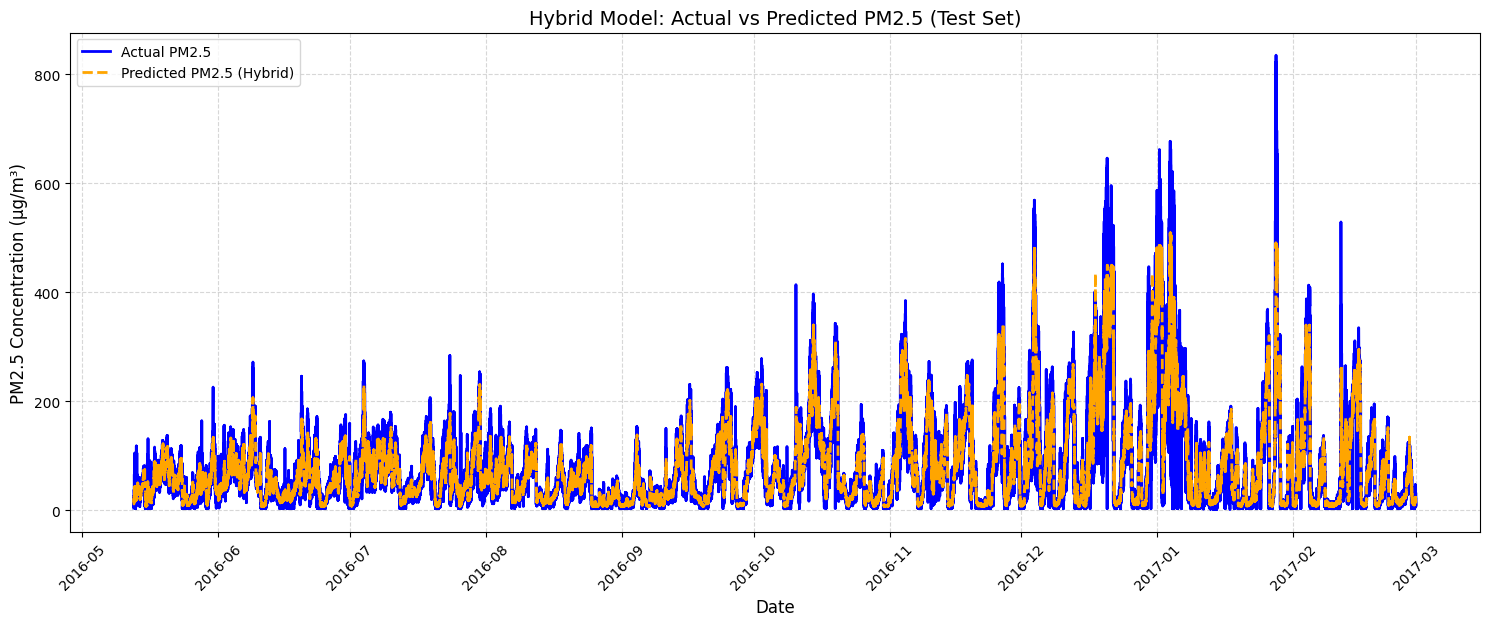

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get test datetime values (aligned after sequence_length)
sequence_length = 7
test_start_idx = len(combined_data_cleaned) - len(y_test)
test_datetimes = combined_data_cleaned['datetime'].iloc[test_start_idx:].values[:len(y_pred_xgb)]

plt.figure(figsize=(15, 6))

plt.plot(test_datetimes, y_test[:len(y_pred_xgb)], label="Actual PM2.5", color='blue', linewidth=2)
plt.plot(test_datetimes, y_pred_xgb, label="Predicted PM2.5 (Hybrid)", color='orange', linestyle='--', linewidth=2)

plt.title("Hybrid Model: Actual vs Predicted PM2.5 (Test Set)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("PM2.5 Concentration (µg/m³)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


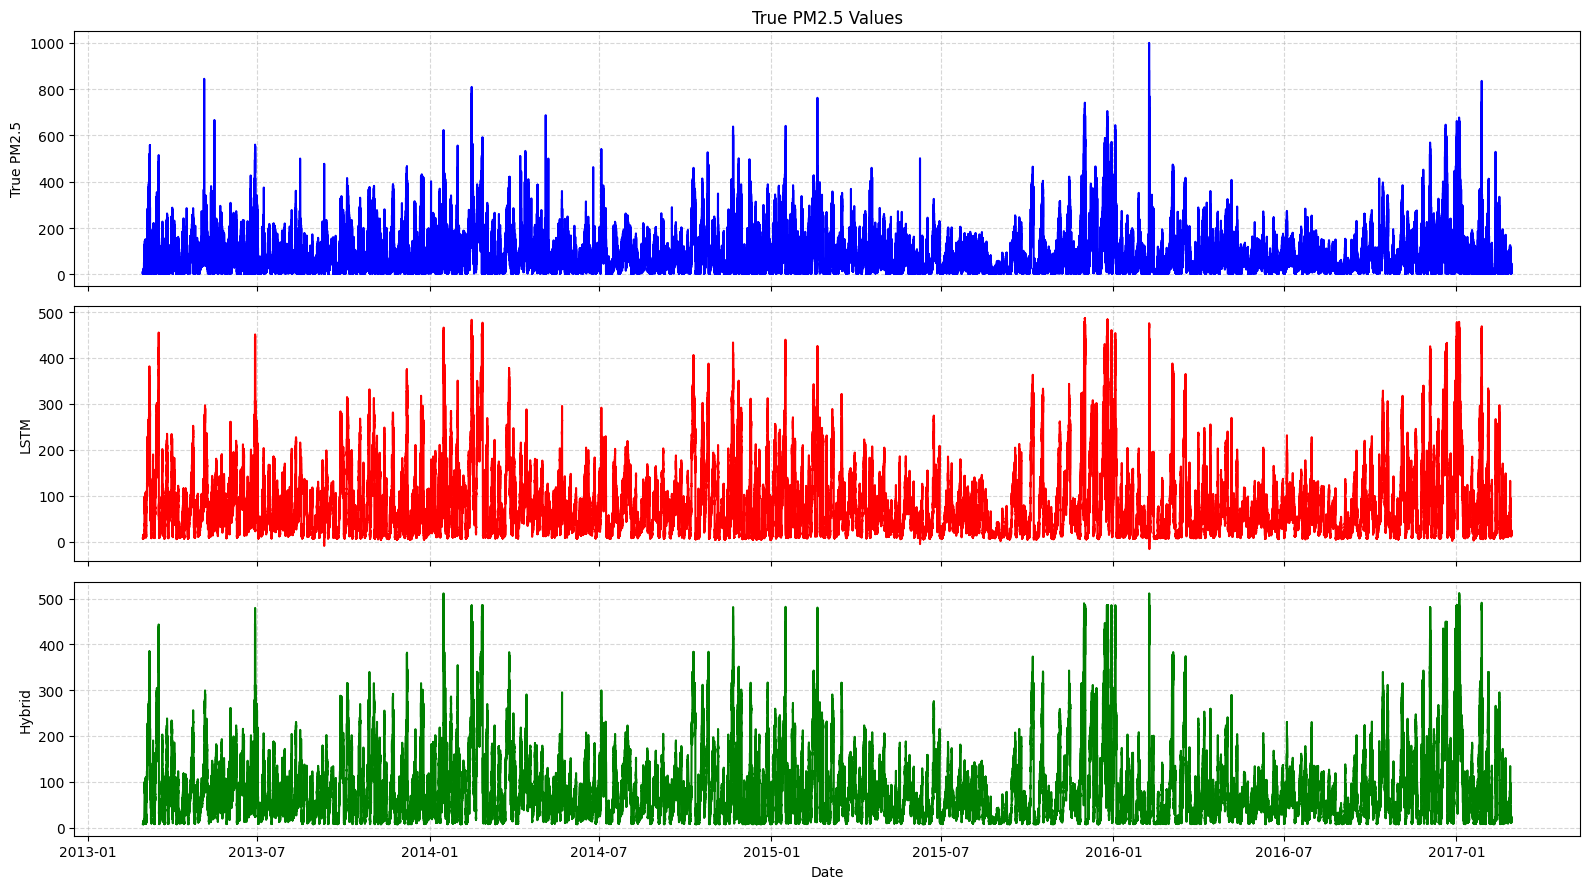

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime is properly parsed
combined_data_cleaned['datetime'] = pd.to_datetime(combined_data_cleaned['datetime'])

# Load aligned predictions (already same length as combined_data_cleaned)
lstm_preds_full = np.load('lstm_preds_full.npy')
xgb_preds_full = np.load('xgb_preds_full.npy')

# Plot full timeline
fig, axs = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

axs[0].plot(combined_data_cleaned['datetime'], combined_data_cleaned['target_7_days_ahead'], color='blue')
axs[0].set_ylabel("True PM2.5")
axs[0].set_title("True PM2.5 Values")

axs[1].plot(combined_data_cleaned['datetime'], lstm_preds_full, color='red')
axs[1].set_ylabel("LSTM")

axs[2].plot(combined_data_cleaned['datetime'], xgb_preds_full, color='green')
axs[2].set_ylabel("Hybrid")
axs[2].set_xlabel("Date")

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



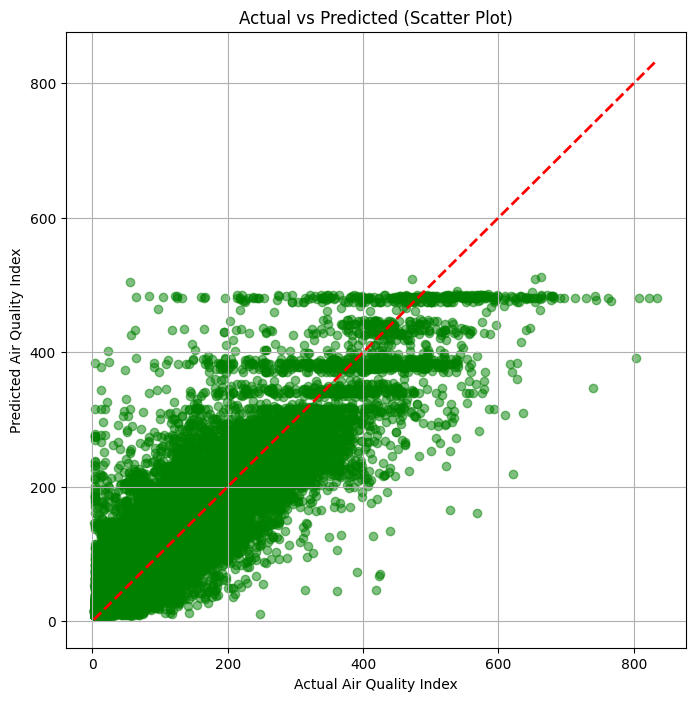

In [ ]:
#Actual vs Predicted (Scatter Plot)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')
plt.title("Actual vs Predicted (Scatter Plot)")
plt.xlabel("Actual Air Quality Index")
plt.ylabel("Predicted Air Quality Index")
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)  # 45-degree line
plt.show()

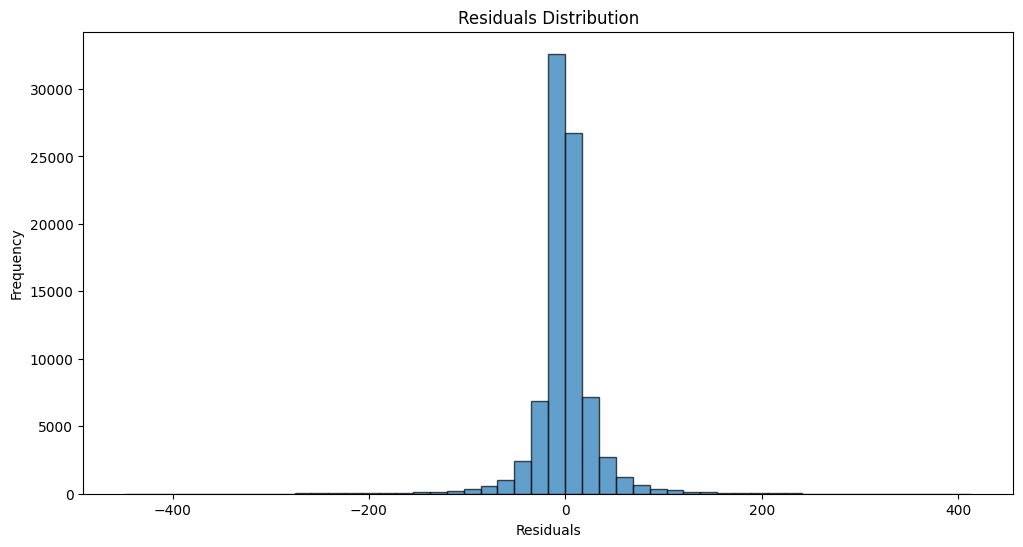

In [ ]:
import matplotlib.pyplot as plt
# Calculate residuals
residuals = y_test - y_pred_xgb  # No need for .values here since y_test is already a NumPy array

# Plot residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


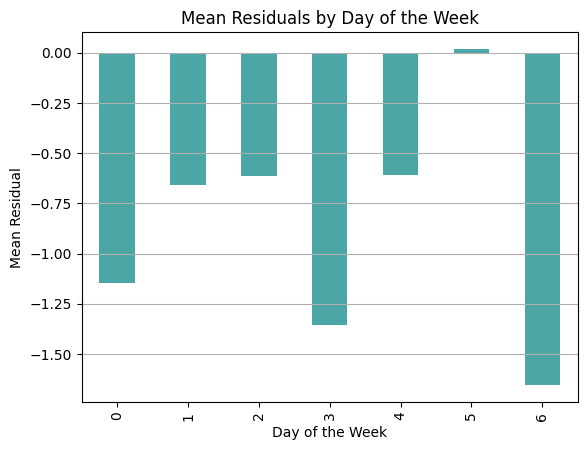

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


#Mean Residuals by Day of the Week
min_length = min(len(y_test), len(y_pred_xgb), len(residuals))
y_test = y_test[:min_length]
y_pred_xgb = y_pred_xgb[:min_length]
residuals = residuals[:min_length]
results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_xgb,
    "Residuals": residuals
})



if 'day_of_week' in combined_data_cleaned.columns:

    results_df['DayOfWeek'] = combined_data_cleaned.loc[y_test.index, 'day_of_week']


    mean_error_by_day = results_df.groupby('DayOfWeek')['Residuals'].mean()


    mean_error_by_day.plot(kind='bar', color='teal', alpha=0.7)
    plt.title("Mean Residuals by Day of the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Mean Residual")
    plt.grid(axis='y')
    plt.show()
else:
    print("'day_of_week' column not found in combined_data_cleaned.")


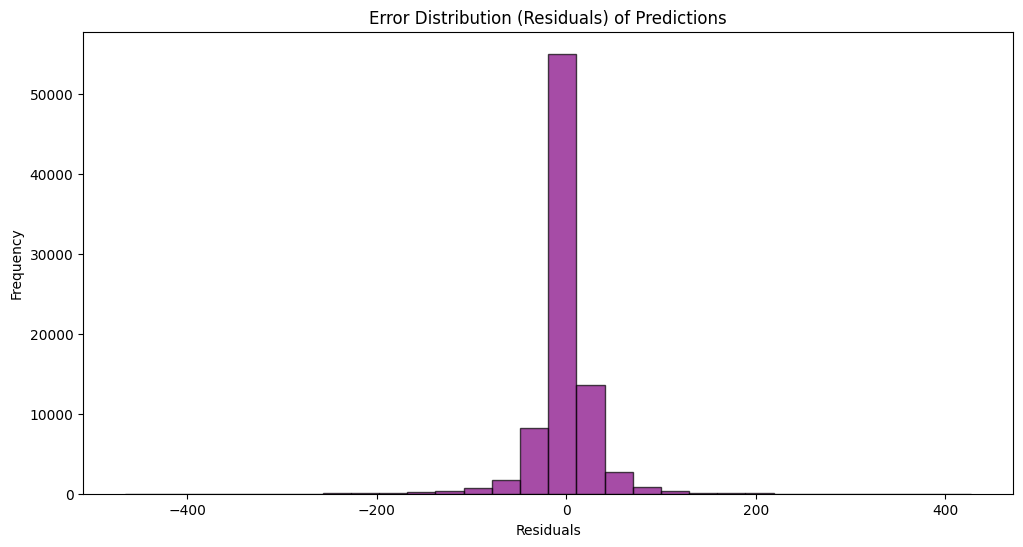

In [ ]:
# Plot distribution of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Error Distribution (Residuals) of Predictions')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


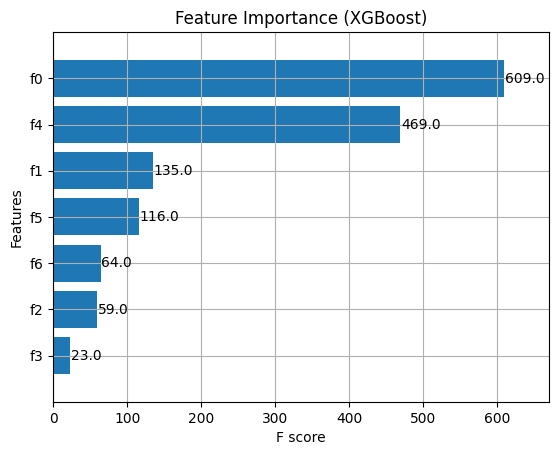

In [ ]:
import xgboost as xgb

# Retrieve feature importance
xgb.plot_importance(random_search.best_estimator_, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Feature Importance (XGBoost)")
plt.show()


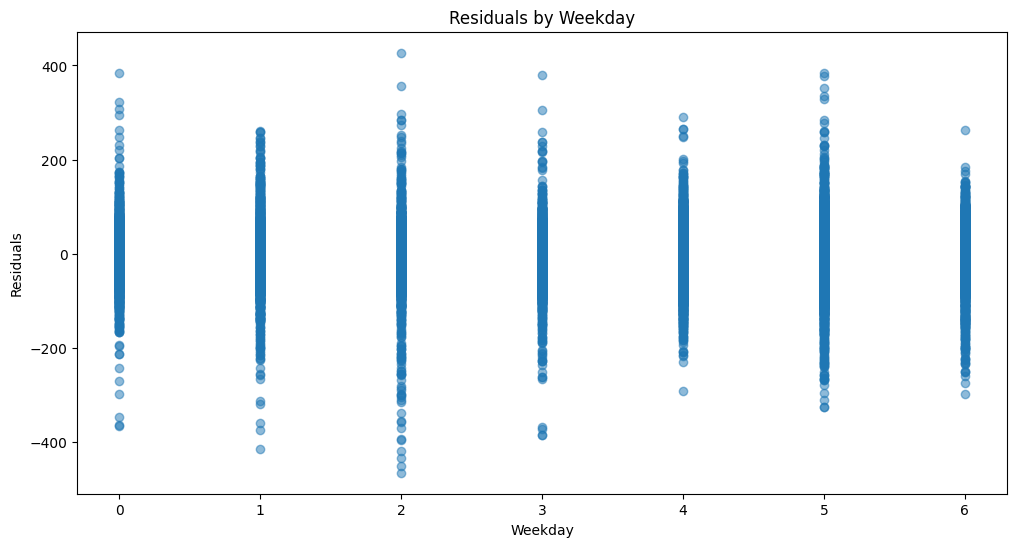

In [ ]:
#Residuals by Weekday
combined_data_cleaned['datetime'] = pd.to_datetime(combined_data_cleaned['datetime'])  # Convert to datetime
combined_data_cleaned['weekday'] = combined_data_cleaned['datetime'].dt.weekday  # Extract weekday
combined_data_cleaned['hour'] = combined_data_cleaned['datetime'].dt.hour  # Extract hour

combined_data_residuals = pd.DataFrame({
    'weekday': combined_data_cleaned['weekday'].iloc[len(combined_data_cleaned) - len(residuals):],
    'residuals': residuals
})

plt.figure(figsize=(12, 6))
plt.scatter(combined_data_residuals['weekday'], combined_data_residuals['residuals'], alpha=0.5)
plt.title('Residuals by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Residuals')
plt.show()


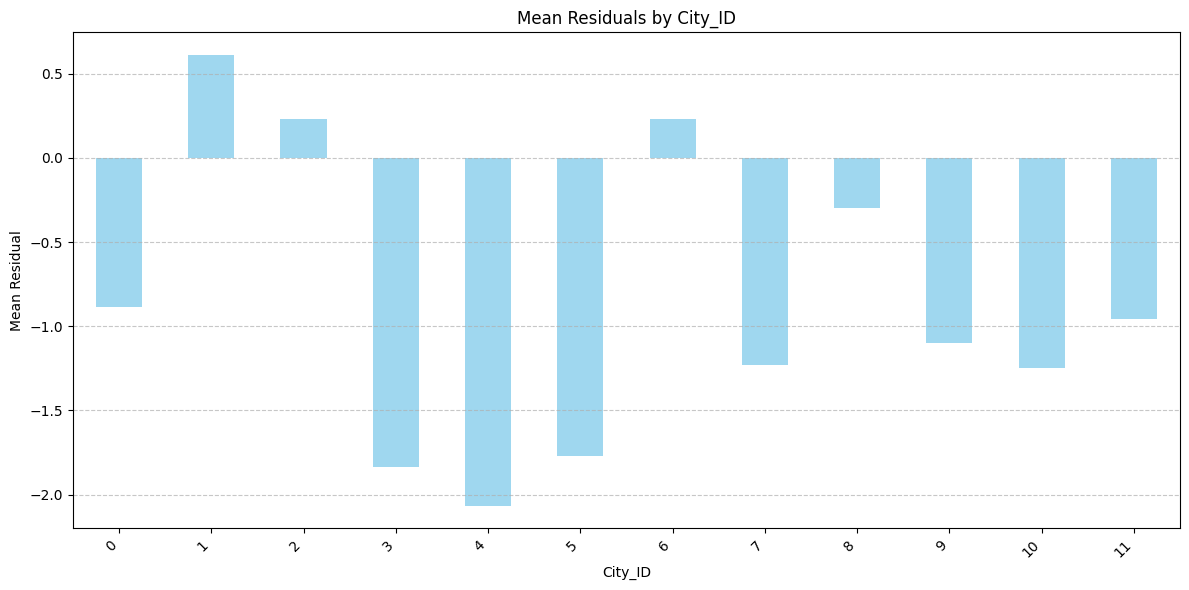

In [ ]:
# Mean Residuals by City_ID
if 'city_id' in combined_data_cleaned.columns:
    # Align 'city_id' column with the test dataset indices
    results_df['City_ID'] = combined_data_cleaned.loc[y_test.index, 'city_id']

    # Calculate the mean residuals grouped by city_id
    mean_error_by_city = results_df.groupby('City_ID')['Residuals'].mean()

    # Plot the mean residuals by city_id
    mean_error_by_city.plot(kind='bar', color='skyblue', alpha=0.8, figsize=(12, 6))
    plt.title("Mean Residuals by City_ID")
    plt.xlabel("City_ID")
    plt.ylabel("Mean Residual")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("'city_id' column not found in combined_data_cleaned.")


In [ ]:
# app.py
from flask import Flask, request, jsonify, render_template
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Initialize Flask app
app = Flask(__name__)

# Load pre-fitted scaler and XGBoost model
scaler = joblib.load('model/scaler.pkl')
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('model/best_xgb_model.json')

# Feature columns expected by model
FEATURE_COLUMNS = [
    'PM2.5_lag_1', 'PM10_lag_1', 'O3_lag_1',
    'PM2.5_rolling_mean', 'PM10_rolling_mean', 'O3_rolling_mean',
    'lstm_pred'
]

@app.route('/')
def home():
    return render_template('index.html')  # Optional front-end

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Input JSON
        input_data = request.get_json()
        data_df = pd.DataFrame([input_data])

        # Separate LSTM prediction
        lstm_pred = data_df[['lstm_pred']].values
        other_features = data_df.drop(columns=['lstm_pred'])

        # Scale features
        other_scaled = scaler.transform(other_features)

        # Combine scaled features with LSTM prediction
        final_input = np.column_stack([lstm_pred, other_scaled])

        # Predict with XGBoost
        prediction = xgb_model.predict(final_input)
        return jsonify({'prediction': float(prediction[0])})

    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)

FileNotFoundError: [Errno 2] No such file or directory: 'model/xgb_model.pkl'